# Setup

In [2]:
import pandas as pd 
from statsmodels.stats import multitest
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.io as pio
import seaborn as sns

In [3]:
#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
#plt.rcParams['axes.facecolor'] = 'white'
#plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [39]:
data_processed = "../../../data/processed/"
graph_data = data_processed + "graph_data_nohubs/"
reports = "../../../reports/reports_nohubs/"

graph_node_data = pd.read_csv(graph_data+"nohub_graph_node_data.csv")
infomap_pathways = pd.read_csv(reports+"analisis_red_genes/infomap_pathways.csv", index_col=[0,1])
louvain_pathways = pd.read_csv(reports+"analisis_red_genes/louvain_pathways.csv", index_col=[0,1])

cols = ["comunidad","tamaño","mean_sim_lsa_0","entropia_0","top_monogram","top_5_monogram","top_monogram_score","top_5_monogram_score"]
infomap_summary = pd.read_pickle(reports+"infomap_summary.pkl")[cols]
louvain_summary = pd.read_pickle(reports+"louvain_summary.pkl")[cols]

# Corrección FDR

Corrijo los pvalores con FDR. Genero una columna que me dice si se rechazó la hipótesis nula para ese par cluster-pathway o no. Me quedo con las filas que tienen "reject" = True, es decir, se rechazó la hipótesis nula. Para esos pares cluster,pathway, tengo el odds ratio que me dice que tan significativa es la correlación entre ellos. Además, por la corrección FDR, se que entre esos pares tengo un 5% de falsos positivos.

In [40]:
infomap_pathways["pvalue"] = multitest.fdrcorrection(infomap_pathways.pvalue.values)[1]
infomap_pathways["reject"] = multitest.fdrcorrection(infomap_pathways.pvalue.values)[0] 

louvain_pathways["pvalue"] = multitest.fdrcorrection(louvain_pathways.pvalue.values)[1]
louvain_pathways["reject"] = multitest.fdrcorrection(louvain_pathways.pvalue.values)[0]

In [56]:
infomap_results = infomap_pathways[infomap_pathways.reject].drop(columns="reject")
louvain_results = louvain_pathways[louvain_pathways.reject].drop(columns="reject")

# Exploro ejemplos

Encontré pathways significativos para todos los clusters?

In [100]:
encontrados_infomap = len(infomap_results.reset_index().cluster.unique())
encontrados_louvain = len(louvain_results.reset_index().cluster.unique())
tot_infomap = len(infomap_summary)
tot_louvain = len(louvain_summary)

print(f"Encontré {encontrados_infomap} infomap y {encontrados_louvain} louvain")
print(f"{round((encontrados_infomap*100)/tot_infomap)}% infomap, {round((encontrados_louvain*100)/tot_louvain)}% louvain")

Encontré 861 infomap y 200 louvain
75% infomap, 68% louvain


Cuantos pathways tienen asociados esos clusters?

,num_pathways
cluster,
130,149
15,134
25,132
17,123
143,120
...,...
543,1
542,1
784,1


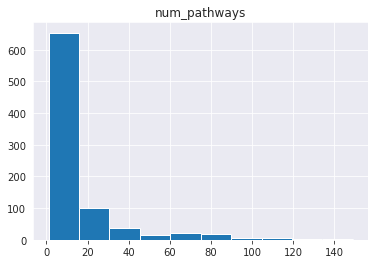

In [139]:
infomap_num_pathways = infomap_results.groupby("cluster").count().sort_values(by="pvalue",ascending=False).drop(columns="odds_ratio").rename(columns={"pvalue":"num_pathways"})
infomap_num_pathways.hist()
infomap_num_pathways

In [136]:
louvain_num_pathways = louvain_results.groupby("cluster").count().sort_values(by="pvalue",ascending=False).drop(columns="odds_ratio").rename(columns={"pvalue":"num_pathways"})
louvain_num_pathways
fig = px.histogram(louvain_num_pathways,x="num_pathways")
fig.show()

Todos los pathways tienen asociadas comunidades? cuantas?

In [121]:
encontrados_infomap = len(infomap_results.reset_index().pathway.unique())
encontrados_louvain = len(louvain_results.reset_index().pathway.unique())
tot_pathways = 2017

print(f"Encontré {encontrados_infomap} infomap y {encontrados_louvain} louvain")
print(f"{round((encontrados_infomap*100)/tot_pathways)}% infomap, {round((encontrados_louvain*100)/tot_pathways)}% louvain")

Encontré 1529 infomap y 1108 louvain
76% infomap, 55% louvain


In [126]:
encontrados_infomap = set(infomap_results.reset_index().pathway.unique())
encontrados_louvain = set(louvain_results.reset_index().pathway.unique())

encontrados_ambos = encontrados_infomap|encontrados_louvain
porc = (len(encontrados_ambos)*100/tot_pathways)
print(f"{round(porc)}% tiene algún cluster asociado (de cualquier particion)")

76% tiene algún cluster asociado (de cualquier particion)


# Ejemplos

## Infomap

In [288]:
cluster = 289
pathways = infomap_results.loc[cluster].sort_values(by="odds_ratio",ascending=False).index.values
infomap_results.loc[cluster].sort_values(by="odds_ratio",ascending=False)

,odds_ratio,pvalue
pathway,,
35554,1384.800000,0.000086
35433,104.539394,0.003311


In [289]:
infomap_summary[infomap_summary.comunidad == cluster]

,comunidad,tamaño,mean_sim_lsa_0,entropia_0,top_monogram,top_5_monogram,top_monogram_score,top_5_monogram_score
186,289,17,0.49,0.46,neurofibromatosis,"[neurofibromatosis, schwannomas, au, lait, nf1]",0.7,"[0.7, 0.32, 0.2, 0.2, 0.2]"


In [290]:
graph_node_data[graph_node_data.comunidades_infomap == cluster]

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
13430,14200,7039_7245_18975_21061_8075,neurofibromatosis,bert_group,primekg,289.0,28.0,0.0,0.0,20.0
19165,20255,C0027831,Neurofibromatosis 1,disease,disgenet,289.0,28.0,2.0,0.0,1.0
23274,5393,24517_14299,schwannomatosis,bert_group,primekg,289.0,28.0,0.0,0.0,3.0
23275,31999,C3810283,SCHWANNOMATOSIS 2,disease,disgenet,289.0,28.0,1.0,0.0,1.0
23276,32514,C4048809,SCHWANNOMATOSIS 1,disease,disgenet,289.0,28.0,3.0,0.0,1.0
28508,25967,C0917817,Neurofibromatosis 3,disease,disgenet,289.0,28.0,5.0,0.0,1.0
28509,21861,C0162678,Neurofibromatoses,disease,disgenet,289.0,28.0,1.0,0.0,1.0
28513,30683,C3150928,NF1 Microdeletion Syndrome,disease,disgenet,289.0,28.0,2.0,0.0,1.0
28514,27303,C1834235,"NEUROFIBROMATOSIS, FAMILIAL SPINAL",disease,disgenet,289.0,28.0,1.0,0.0,1.0
28519,26661,C1335929,Schwannomatosis,disease,disgenet,289.0,28.0,4.0,0.0,1.0


In [291]:
graph_node_data.set_index("node_index").loc[pathways]

,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
node_index,,,,,,,,,
35554,R-HSA-6802953,RAS signaling downstream of NF1 loss-of-functi...,pathway,primekg_REACTOME,NaN,NaN,0.0,7.0,0.0
35433,R-HSA-5658442,Regulation of RAS by GAPs,pathway,primekg_REACTOME,NaN,NaN,0.0,68.0,0.0


Armar un pipeline "keyword" -> cluster -> wordcloud, pathways

## Louvain

In [277]:
cluster = 28
pathways = louvain_results.loc[cluster].sort_values(by="odds_ratio",ascending=False).index.values
louvain_results.loc[cluster].sort_values(by="odds_ratio",ascending=False)

,odds_ratio,pvalue
pathway,,
36112,inf,0.004476
36061,inf,0.000208
36031,inf,0.000208
36030,inf,0.004476
36029,inf,0.000208
...,...,...
36212,4.895217,0.001288
36203,4.305569,0.004769
35909,4.259820,0.001002


In [278]:
louvain_summary[louvain_summary.comunidad == cluster]

,comunidad,tamaño,mean_sim_lsa_0,entropia_0,top_monogram,top_5_monogram,top_monogram_score,top_5_monogram_score
29,28,177,0.19,0.67,tumor,"[tumor, astrocytoma, neoplasm, malignant, cell]",0.41,"[0.41, 0.36, 0.27, 0.24, 0.23]"


In [279]:
graph_node_data[graph_node_data.comunidades_louvain == cluster]

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
163,27001,C1621958,Glioblastoma Multiforme,disease,disgenet,217.0,28.0,111.0,0.0,7.0
549,21959,C0205944,"Sarcoma, Epithelioid",disease,disgenet,464.0,28.0,14.0,0.0,1.0
3796,18771,C0006118,Brain Neoplasms,disease,disgenet,110.0,28.0,39.0,0.0,16.0
3813,21627,C0153633,Malignant neoplasm of brain,disease,disgenet,110.0,28.0,38.0,0.0,5.0
3821,25020,C0677866,Brain Stem Neoplasms,disease,disgenet,57.0,28.0,4.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...
35743,26402,C1321427,Epithelioid Malignant Peripheral Nerve Sheath ...,disease,disgenet,465.0,28.0,0.0,0.0,1.0
35744,26730,C1370658,Intraneural perineurioma,disease,disgenet,444.0,28.0,0.0,0.0,2.0
35772,26145,C1263886,Neoplasm of frontal lobe,disease,disgenet,110.0,28.0,0.0,0.0,1.0
35773,26146,C1263887,Neoplasm of temporal lobe,disease,disgenet,110.0,28.0,0.0,0.0,1.0


In [280]:
graph_node_data.set_index("node_index").loc[pathways]

,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
node_index,,,,,,,,,
36112,R-HSA-9670615,Defective Inhibition of DNA Recombination at T...,pathway,primekg_REACTOME,NaN,NaN,0.0,2.0,0.0
36061,R-HSA-9649913,RAS GTPase cycle mutants,pathway,primekg_REACTOME,NaN,NaN,0.0,3.0,0.0
36031,R-HSA-9632700,Evasion of Oxidative Stress Induced Senescence...,pathway,primekg_REACTOME,NaN,NaN,0.0,3.0,0.0
36030,R-HSA-9632697,Evasion of Oxidative Stress Induced Senescence...,pathway,primekg_REACTOME,NaN,NaN,0.0,2.0,0.0
36029,R-HSA-9630794,Evasion of Oncogene Induced Senescence Due to ...,pathway,primekg_REACTOME,NaN,NaN,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...
36212,R-HSA-983231,Factors involved in megakaryocyte development ...,pathway,primekg_REACTOME,NaN,NaN,0.0,109.0,0.0
36203,R-HSA-977225,Amyloid fiber formation,pathway,primekg_REACTOME,NaN,NaN,0.0,110.0,0.0
35909,R-HSA-9018519,Estrogen-dependent gene expression,pathway,primekg_REACTOME,NaN,NaN,0.0,149.0,0.0
